### Deliverable 1: Preprocessing the Data for a Neural Network

In [8]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
#
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import os
#
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import math

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [9]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
#
application_df = application_df.drop(columns=['EIN'])
application_df

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...
34294,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [10]:
# Determine the number of unique values in each column.
#
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [11]:
frequency_name = pd.DataFrame(
{
    'NAME':application_df['NAME'].value_counts().index.tolist(),
    'COUNT':list(application_df['NAME'].value_counts())
})
frequency_name

,NAME,COUNT
0,PARENT BOOSTER USA INC,1260
1,TOPS CLUB INC,765
2,UNITED STATES BOWLING CONGRESS INC,700
3,WASHINGTON STATE UNIVERSITY,492
4,AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,408
...,...,...
19563,ST LOUIS SLAM WOMENS FOOTBALL,1
19564,AIESEC ALUMNI IBEROAMERICA CORP,1
19565,WEALLBLEEDRED ORG INC,1
19566,AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP &...,1


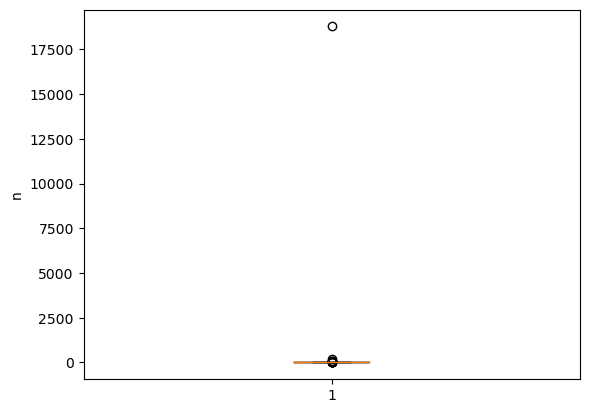

Lower bound = -3.875
Upper bound = 9.125


In [14]:
# Create boxplot (count frequency)
repeating_requesters = frequency_name['COUNT'].value_counts()
fig1, ax1 = plt.subplots()
ax1.set_ylabel('n')
ax1.boxplot(repeating_requesters)
plt.show()

# Calculate the quartiles (IQR for repeated requesters)
quartiles = np.quantile(repeating_requesters,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

# Print Upper & lower Bounds
print(f'Lower bound = {lower_bound}')
print(f'Upper bound = {upper_bound}')


In [15]:

frequency_name.loc[frequency_name['COUNT']>upper_bound]

,NAME,COUNT
0,PARENT BOOSTER USA INC,1260
1,TOPS CLUB INC,765
2,UNITED STATES BOWLING CONGRESS INC,700
3,WASHINGTON STATE UNIVERSITY,492
4,AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,408
...,...,...
217,NATIONAL ASSOCIATION OF LETTER CARRIERS,10
218,AMERICAN FEDERATION OF LABOR AND CONGRESS OF I...,10
219,NATIONAL ASSOCIATION OF HISPANIC NURSES,10
220,SNOHOMISH HIGH SCHOOL PANTHER PARENTS CLUB,10


In [16]:
# Replace in dataframe
for name_entry in list(frequency_name.loc[frequency_name['COUNT']<=upper_bound]['NAME']):
    application_df['NAME'] = application_df['NAME'].replace(name_entry,"Other")
# Check successful binning
application_df['NAME'].value_counts()

Other                                      21022
PARENT BOOSTER USA INC                      1260
TOPS CLUB INC                                765
UNITED STATES BOWLING CONGRESS INC           700
WASHINGTON STATE UNIVERSITY                  492
                                           ...  
CASCADE 4-H FOUNDATION                        10
FREE & ACCEPTED MASONS OF WASHINGTON          10
NEW MEXICO GARDEN CLUBS INC                   10
NATIONAL ASSOCIATION OF HISPANIC NURSES       10
UNION OF CALIFORNIA STATE WORKERS             10
Name: NAME, Length: 223, dtype: int64

In [17]:
# Check INCOME_AMT count for binning
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [18]:
# Values to replace if income < than 100,000
replace_income=[
    '100000-499999',
    '1M-5M',
    '5M-10M',
    '10M-50M',
    '50M+'
]

# Replace in dataframe
for income in replace_income:
    application_df.INCOME_AMT = application_df.INCOME_AMT.replace(income,">100,000")
    
# Check successful binning 
application_df.INCOME_AMT.value_counts()

0              24388
>100,000        4893
25000-99999     3747
1-9999           728
10000-24999      543
Name: INCOME_AMT, dtype: int64

In [19]:
application_df.SPECIAL_CONSIDERATIONS = application_df.loc[(application_df.SPECIAL_CONSIDERATIONS == 'N'),'SPECIAL_CONSIDERATIONS'] = 0
application_df.SPECIAL_CONSIDERATIONS = application_df.loc[(application_df.SPECIAL_CONSIDERATIONS == 'Y'),'SPECIAL_CONSIDERATIONS'] = 1
application_df.SPECIAL_CONSIDERATIONS

0        1
1        1
2        1
3        1
4        1
        ..
34294    1
34295    1
34296    1
34297    1
34298    1
Name: SPECIAL_CONSIDERATIONS, Length: 34299, dtype: int64

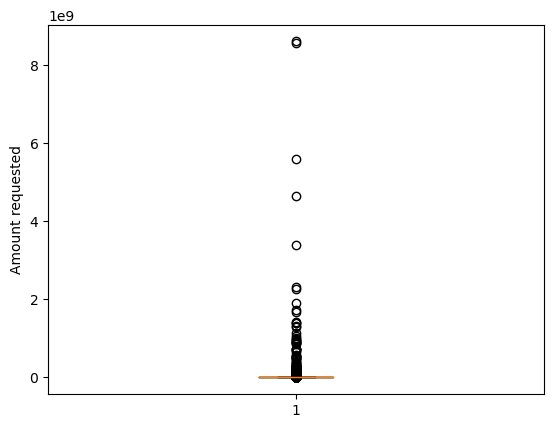

In [22]:
# Boxplot with requested amount
req_amount = list(application_df.ASK_AMT)
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Amount requested')
ax1.boxplot(req_amount)
plt.show()

In [31]:
 # Data points outside of the 1.5*IQR range
quartiles = np.quantile(req_amount,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

print(f'Lower bound = {lower_bound}')
print(f'Upper bound = {upper_bound}')
print(f'Minimum requested = {min(req_amt)}')
print(f'Maximum requested = {max(req_amt)}')
print(f'Number of requests > upper bound = {len(application_df.loc[(application_df.ASK_AMT > upper_bound) | (application_df.ASK_AMT < lower_bound)])}')
print(f'Number of requests in range = {len(application_df) - len(application_df.loc[(application_df.ASK_AMT > upper_bound) | (application_df.ASK_AMT < lower_bound)])}')
application_df.ASK_AMT.value_counts()

Lower bound = 887.0
Upper bound = 11855.0
Minimum requested = 5000
Maximum requested = 8597806340
Number of requests > upper bound = 8206
Number of requests in range = 26093


5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [32]:
# Look at APPLICATION_TYPE value counts for binning
#  
application_df['APPLICATION_TYPE'].value_counts()


T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

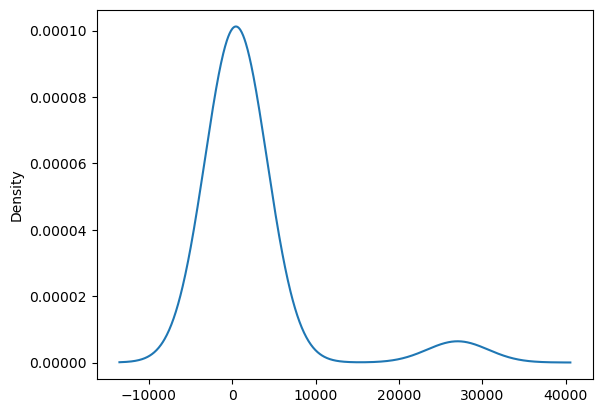

In [33]:
# Visualize the value counts of APPLICATION_TYPE
# 
application_df['APPLICATION_TYPE'].value_counts().plot.density()

In [34]:
# Determine which values to replace if counts are less than ...?
#  
replace_application=list(application_df['APPLICATION_TYPE'].value_counts()[application_df['APPLICATION_TYPE'].value_counts()<500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [35]:
# Look at CLASSIFICATION value counts for binning
#  
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

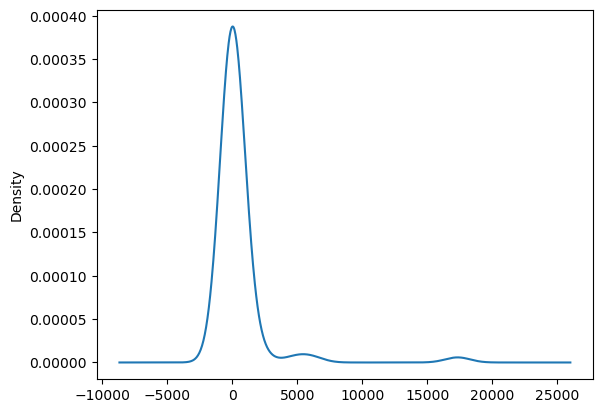

In [36]:
# Visualize the value counts of CLASSIFICATION
#  
application_df.CLASSIFICATION.value_counts().plot.density()

In [37]:
# Determine which values to replace if counts are less than ..?
#  
replace_class = list(application_df.CLASSIFICATION.value_counts()[application_df.CLASSIFICATION.value_counts() < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [38]:
# Generate our categorical variable lists
#  
application_cat = application_df.dtypes[application_df.dtypes == 'object'].index.tolist()
application_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [39]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
#  
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

C:\Users\gcaza\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_25000-99999,"INCOME_AMT_>100,000"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [40]:
# Merge one-hot encoded features and drop the originals
#  
application_df = application_df.merge(encode_df, left_index=True,right_index=True)
application_df = application_df.drop(application_cat,axis=1)
application_df.head()

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_25000-99999,"INCOME_AMT_>100,000"
0,1,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [41]:
# Split our preprocessed data into our features and target arrays
#  
y = application_df.IS_SUCCESSFUL.values
X = application_df.drop(columns='IS_SUCCESSFUL').values

# Split the preprocessed data into a training and testing dataset
#  
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18)

In [42]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [46]:
# New sequential model with hyperparameter options
def create_model(hp):
    neuralnetwork_model = tf.keras.models.Sequential()

    # activation functions
    activation = hp.Choice('activation',['relu','sigmoid'])
    # number of neurons first layer
    neuralnetwork_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=len(X_train[0])), activation=activation, input_dim=len(X_train[0])))
    # hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 2)):
        neuralnetwork_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=math.floor(len(X_train[0])/2)),activation=activation))
    
    neuralnetwork_model.add(tf.keras.layers.Dense(units=1, activation="tanh"))

    # Compile  model
    neuralnetwork_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return neuralnetwork_model

In [47]:
# Kerastuner library
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=25,
    hyperband_iterations=2,
    overwrite=True)

In [50]:
# The model's weights are saved every 5 epochs
# (Stackoverflow)
os.makedirs("checkpoints_optimized/",exist_ok=True)

class WeightsSaver(Callback):
    f_count = 0
    def __init__(self, N):
        self.N = N
        self.epoch = 1
        WeightsSaver.f_count += 1
    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.N == 0:
            os.makedirs(f'checkpoints_optimized/Trial_Model_{WeightsSaver.f_count}/',exist_ok=True)
            name = f'checkpoints_optimized/Trial_Model_{WeightsSaver.f_count}/weightsEpoch_{self.epoch}.h5'
            self.model.save_weights(name)
        self.epoch += 1

In [51]:
 # Run the kerastuner suggested hyperparameters
tuner.search(X_train_scaled,y_train,epochs=25,validation_data=(X_test_scaled,y_test),callbacks=[WeightsSaver(5)])

Trial 60 Complete [00h 01m 12s]
val_accuracy: 0.7753936052322388

Best val_accuracy So Far: 0.7783090472221375
Total elapsed time: 00h 29m 44s
INFO:tensorflow:Oracle triggered exit


In [52]:
# Get top three hyperparameters and print values
top_hyperparams = tuner.get_best_hyperparameters(3)
for param in top_hyperparams:
    print(param.values)

{'activation': 'relu', 'first_units': 183, 'num_layers': 2, 'units_0': 34, 'units_1': 32, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
{'activation': 'relu', 'first_units': 41, 'num_layers': 2, 'units_0': 4, 'units_1': 105, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}
{'activation': 'relu', 'first_units': 164, 'num_layers': 2, 'units_0': 49, 'units_1': 39, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0048'}


In [53]:
# Evaluate top three models vs test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5655 - accuracy: 0.7783 - 603ms/epoch - 2ms/step
Loss: 0.5655328631401062, Accuracy: 0.7783090472221375
268/268 - 1s - loss: 0.4611 - accuracy: 0.7777 - 587ms/epoch - 2ms/step
Loss: 0.46112585067749023, Accuracy: 0.7777259349822998
268/268 - 1s - loss: 0.5592 - accuracy: 0.7777 - 574ms/epoch - 2ms/step
Loss: 0.5591586828231812, Accuracy: 0.7777259349822998


In [54]:
best_model = top_model[0]
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 183)               47946     
                                                                 
 dense_1 (Dense)             (None, 34)                6256      
                                                                 
 dense_2 (Dense)             (None, 32)                1120      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55,355
Trainable params: 55,355
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile 
best_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [57]:
# Train the model
#  
fit_model = best_model.fit(X_train_scaled,y_train,epochs=35,callbacks=[WeightsSaver(5)])

Epoch 1/35
804/804 [==============================] - 3s 3ms/step - loss: 0.5553 - accuracy: 0.7859
Epoch 2/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5486 - accuracy: 0.7874
Epoch 3/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5471 - accuracy: 0.7890
Epoch 4/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5501 - accuracy: 0.7884
Epoch 5/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5502 - accuracy: 0.7886
Epoch 6/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5523 - accuracy: 0.7888
Epoch 7/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5504 - accuracy: 0.7890
Epoch 8/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5523 - accuracy: 0.7879
Epoch 9/35
804/804 [==============================] - 2s 3ms/step - loss: 0.5531 - accuracy: 0.7874
Epoch 10/35
804/804 [==============================] - 3s 3ms/step - loss: 0.5490 - accuracy: 0.7880

In [62]:
# Evaluate the model using the test data
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6015 - accuracy: 0.7801 - 391ms/epoch - 1ms/step
Loss: 0.6014941334724426, Accuracy: 0.7800583243370056


In [67]:
# Restore the model weights 
best_model.load_weights("checkpoints_optimized/Trial_Model_2/weightsEpoch_5.h5")

In [68]:
# Evaluate the model using data
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5794 - accuracy: 0.7752 - 373ms/epoch - 1ms/step
Loss: 0.5794205665588379, Accuracy: 0.7751603722572327
